In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold 
#feature의 variance가 적다는 말은 정보가 별로 없다는 말일 수도 있다. 100개의 샘플의 데이터가 99개 1 1개 0이면
#별로 배울게 없는 데이터이다.
from sklearn.feature_selection import SelectFromModel
#모델의 중요도에 따라서 선택하는 것.
#어떤 특성은 0으로 예측 했을 때 중요한 특성이 1로 하니까 중요도가 안 좋아지는 경우 ==> 중요한 특성
#그런데 0으로 하든 1로 하든 중요도가 변함이 없는 경우 ==> 안중요
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_rows', 100)

In [ ]:
DEBUG = True

In [ ]:
if DEBUG :
    NROWS = 500000
else :
    NROWS = None

In [134]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')


In [ ]:
train.shape

### 읽을 데이터가 너무 크다!
* pd.read_csv('....', nrows=integer) 또는
* sample의 fraction을 이용하는 것도 한 방법(random성 있음)
* imbalance data가 걱정 되는 경우 StratifiedSampling 이용


In [ ]:
train = pd.read_csv('../input/train.csv')
train = train.sample(frac=0.1)
train.shape

### Stratified Sampling 깔끔하게 하기 꿀팁!

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
fold = StratifiedKFold(n_splits=10, random_state =42)

In [ ]:
# index뽑기
for trn_idx, tst_idx in fold.split(train, train['target']):
    break

In [ ]:
trn_idx

In [ ]:
train.iloc[trn_idx]

In [ ]:
test.iloc[tst_idx]

깔끔!

In [ ]:
cat_cols = [col for col in train.columns if 'cat' in col]

In [ ]:
cat_cols

In [ ]:
train[cat_cols[0]].value_counts()

In [ ]:
# category의 유니크한 개수
for col in cat_cols:
    print(col,':', train[col].nunique() )
    #high cardinality : ps_cal_11_cat ==> 104개 
    #(one-hot-encoding하게 되면 머리아파짐,, 다른 encoding방법이 필요)

In [ ]:
train.shape

In [ ]:
train = train.drop_duplicates()
train.shape
#중복된 값 없음

In [ ]:
test = test.drop_duplicates()
test.shape

dummy feature에 one_hot_encoding을 실시할 것

In [ ]:
train.info() #object는 없다 --> label_encoding 필요 없음

### Metadata
To facilitate the data management, we'll store meta-inforamtation about the variablel in a DataFrame. This will be helpful when we wnat to select specific variables for analysis, visualization, modeling,...

Concretely we will store:
* role : input, ID, target
* level : nominal, interval, ordinal, binary
* keep : True, False
* dtype : int, float, str


In [135]:
data = []
for f in train.columns:
    if f == 'target' :
         role = 'target'
    elif f == 'id':
        role = 'id'
    else : 
        role = 'input'
        
    #Defining the level
    if 'bin' in f or f == 'target':
        level =  'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    #Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    #Defining the data type    
    dtype = train[f].dtype
    #Crearting a Dict that contains all the metadata for the variable
    f_dict = {
        'varname':f,
        'role':role,
        'level':level,
        'keep': keep,
        'dtype':dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns = ['varname','role','level','keep','dtype'])
meta.set_index('varname',inplace=True)

In [136]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


Example to extract all nominal variables that are not dropped

In [137]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

Below the number of variables per role and level are displayed

In [138]:
pd.DataFrame({'count': meta.groupby(['role','level'])
             ['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


정리를 이쁘게 했다.

### Descriptive Statistics
We can also apply the describe method on the dataframe. However, it doesn't make much sense to calculate the mean, std,... on categorical variables and the id variable. We'll explore the categorical variables visually later.

Thanks to our meta file we can easily select the variables on which we want to compute the descriptive statistics. To keep things clear, we'll do this per data type.

Interval variables

In [139]:
categorical_feat = [col for col in train.columns if 'cat' in col]

In [140]:
categorical_feat #이런식으로 뽑는 것도 가능하다

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [141]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


reg variables
* only ps_reg_03 has missing values
* the range(min to max) differs between the variables. We could apply scaling(e.g StandardScaler), but it depends on the classifier we will want to use.
* linear regression일 경우, feature들 간의 distribution이 너무 다르, 특정 var에 쏠리는 경우가 발생함. StandardScaler사용.(선형모델)
* Tree 모델을 사용할 경우, 절대값의 크기에 영향 별로 안받음. 굳이 안해도 됨

car variables
* ps_car_12 and ps_car_15 have missing values
* again, the range differs and we could apply scaling.

calc variables
* no missing values
* this seems to be some kind of ratio as the maximum is 0.9
* all three `_calc` variables have very similar distributions

__Overall,__ we can see that the range of the interval variables is rather small. Perhaps some transformation(e.g log) is already applied in order to anoymize the data?

Ordinal variables





In [142]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


* Only one missing variable: ps_car_11
* We could apply sacling to deal with the different ranges

Binary variables

In [143]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- A priori in the train data is 3.645%, which is __strongly imbalanced.__
- From the means we can conclude that for most variables the value is zero in most cases. (대부분이 보험 청구가 안되었다.)

### Handling imbalanced classes
As we mentioned above the proportion of records with target = 1 is far less than target=0. This lead to a model that has great accuracy but does have any added value in practice. Two possible strategies to deal with this problem are:
- oversampling records with target=1
- undersampling records with target=0
There are many more strategies of course and MachineLearningMastery.com gives a nice overview. As we have a rather large training set, se can go for __undersamplling.__

얼마나 1을 잘 맞추느냐가 중요한 상황. gini나 ROC AUC를 사용하는 이유.  
undersampling 많은 걸 줄임, target이 0인 걸 줄일 것


SMOTE!

In [144]:
desired_apriori = 0.10

#Get the indices per target value
idx_0 = train[train.target ==0].index
idx_1 = train[train.target == 1].index

#Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target =0
undersampling_rate = ((1-desired_apriori)*nb_1) / (nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

#Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples = undersampled_nb_0)

#construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

#return undersampled data frame
train = train.loc[idx_list].reset_index(drop=True) #shuffle해줬으니까 순서대로

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


In [85]:
nb_0

573518

In [86]:
nb_1

21694

### Data Quality Checks

* Checking missing values  
Missings are represeted as -1

In [145]:
vars_with_missing = []
for f in train.columns :
    missings = train[train[f] == -1][f].count()
    if missings > 0 :
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))


Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


- ps_car_03_cat and ps_car_05_cat have a large proportion of recoreds with missing values. Remove these variables.
- For the other categorical variables with missing values, we can leave the missing value -1 as such.
- ps_reg_03(continuois) has missing values for 18% of all records. Replace by the mean
- ps_car_11(ordinal) has only 5 records with missing values. Replace by the mode.
- ps_car_12(continuous)has only 1records with missing value. Replace by the mean.
- ps_car_14(continuous) has missing values for 7% of all records. Replace by the mean.

### Missing Value는 함부로 채우면 안된다
모델을 학습시켜서 채우는 방법도 있다.

가끔씩 missing value값이 확 뛸 때가 있음. 이경우는 missing value에 정보가 있다는 말일 수 도 있음. 하지만 porto에서는 정보가 없다.

In [146]:
#Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop), 'keep'] = False

In [147]:
mean_imp.fit_transform(train[['ps_car_14']]).shape

(216940, 1)

In [148]:
#Imputing with the mean or mode
mean_imp = Imputer(missing_values=-1, strategy='mean', axis=0)
mode_imp = Imputer(missing_values=-1, strategy='most_frequent', axis=0)
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_reg_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mean_imp.fit_transform(train[['ps_car_11']]).ravel()

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### Checing the cardinality of the categorical variables
Cardinality refers to the number of different values in a variable. As we will create dummy variables from the categorical variables later on, we need to check whether there are variables with many distinct values. We should handle these variables differently as they would result in many dummy variables.

In [149]:
v = meta[(meta.level =='nominal') & (meta.keep)].index
for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Varaible {} has {} distinct values'.format(f, dist_values))

Varaible ps_ind_02_cat has 5 distinct values
Varaible ps_ind_04_cat has 3 distinct values
Varaible ps_ind_05_cat has 8 distinct values
Varaible ps_car_01_cat has 13 distinct values
Varaible ps_car_02_cat has 3 distinct values
Varaible ps_car_04_cat has 10 distinct values
Varaible ps_car_06_cat has 18 distinct values
Varaible ps_car_07_cat has 3 distinct values
Varaible ps_car_08_cat has 2 distinct values
Varaible ps_car_09_cat has 6 distinct values
Varaible ps_car_10_cat has 3 distinct values
Varaible ps_car_11_cat has 104 distinct values


In [150]:
train[v[0]].value_counts().shape[0]

5

In [151]:
train[v[0]].nunique() # 같은 결과

5

One hot Encoding 하는데 Cardinality가 높다면, 많은 distinct values들이 있다면, 1000개의 칼럼 계산할게 너무 많아짐.

Only ps_car_11 has many distinct values, although it is still reasonable.

EDIT: nickycan made an excellent remark on the fact that my first solution could lead to data leakage. He also pointed me to another kernel made by oliver which deals with that. I therefore replaced this part with the kernel of oliver. All credits go to him. It is so great what you can learn by participating in the Kaggle competitions :)

74개의 칼럼이 생기게 되는데...Accept할지 말지는 알아서 결정.

칼럼이 너무 많아지면, 트리모델을 사용할 경우, 트리의 깊이도 깊어지고, 중요한 질문을 못 건드릴 가능성 높아짐, 답으로 가기 위한 과정에서 멀어짐, 원하지 않는 split이 생길 수 있음. one hot encoding많아지면 힘들다... ==> mean encoding(Overfitting 가능성, 그래서 noise를 추가해줌) OR Frequency Encoding 사용한다.

## Mean Encoding

In [152]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [153]:
trn_series = train["ps_car_11_cat"]
tst_series = test["ps_car_11_cat"]
target = train.target
min_samples_leaf = 100
smoothing = 10
noise_level = 0.01

In [154]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

In [155]:
temp = pd.concat([trn_series, target], axis=1)

In [156]:
temp.groupby(by = trn_series.name)[target.name].agg(['mean', 'count'])

,mean,count
ps_car_11_cat,,
1,0.108260,1247
2,0.103082,941
3,0.139078,1172
4,0.164966,588
5,0.113000,4646
6,0.101883,903
7,0.071571,2012
8,0.102762,905
9,0.076923,806


In [157]:
averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])

In [158]:
# distribution smoothing
smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))

In [101]:
smoothing

ps_car_11_cat
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
10     1.0
11     1.0
12     1.0
13     1.0
14     1.0
15     1.0
16     1.0
17     1.0
18     1.0
19     1.0
20     1.0
21     1.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
30     1.0
31     1.0
32     1.0
33     1.0
34     1.0
35     1.0
36     1.0
37     1.0
38     1.0
39     1.0
40     1.0
41     1.0
42     1.0
43     1.0
44     1.0
45     1.0
46     1.0
47     1.0
48     1.0
49     1.0
50     1.0
      ... 
55     1.0
56     1.0
57     1.0
58     1.0
59     1.0
60     1.0
61     1.0
62     1.0
63     1.0
64     1.0
65     1.0
66     1.0
67     1.0
68     1.0
69     1.0
70     1.0
71     1.0
72     1.0
73     1.0
74     1.0
75     1.0
76     1.0
77     1.0
78     1.0
79     1.0
80     1.0
81     1.0
82     1.0
83     1.0
84     1.0
85     1.0
86     1.0
87     1.0
88     1.0
89     1.0
90     1.0
91     1.0
92     1.0
93     

In [159]:
prior = target.mean()

In [160]:
prior

0.1

In [161]:
averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing

In [105]:
averages

,mean,count,target
ps_car_11_cat,,,
1,0.108260,1247,0.108260
2,0.103082,941,0.103082
3,0.139078,1172,0.139078
4,0.164966,588,0.164966
5,0.113000,4646,0.113000
6,0.101883,903,0.101883
7,0.071571,2012,0.071571
8,0.102762,905,0.102762
9,0.076923,806,0.076923


In [162]:
ft_trn_series = pd.merge(trn_series.to_frame(trn_series.name), 
                        averages.reset_index().rename(columns = 
                            {'index':target.name, target.name : 'average'}))

In [107]:
averages #target의 mean을 smoothing한 정보만 남는다.

,mean,count,target
ps_car_11_cat,,,
1,0.108260,1247,0.108260
2,0.103082,941,0.103082
3,0.139078,1172,0.139078
4,0.164966,588,0.164966
5,0.113000,4646,0.113000
6,0.101883,903,0.101883
7,0.071571,2012,0.071571
8,0.102762,905,0.102762
9,0.076923,806,0.076923


In [163]:
trn_series.to_frame(trn_series.name), averages.reset_index()

(        ps_car_11_cat
 0                  26
 1                 104
 2                  15
 3                  74
 4                  78
 5                  27
 6                  11
 7                  10
 8                 102
 9                  80
 10                 65
 11                 19
 12                 64
 13                102
 14                 78
 15                 64
 16                 60
 17                104
 18                104
 19                 47
 20                 25
 21                 60
 22                 26
 23                 83
 24                104
 25                 64
 26                 60
 27                 12
 28                 92
 29                 65
 30                 66
 31                 57
 32                 32
 33                 32
 34                104
 35                 70
 36                104
 37                 82
 38                 55
 39                 65
 40                  5
 41                 29
 42        

In [164]:
averages.reset_index().rename(columns={'index' : target.name, target.name : 'average'})

,ps_car_11_cat,mean,count,average
0,1,0.108260,1247,0.108260
1,2,0.103082,941,0.103082
2,3,0.139078,1172,0.139078
3,4,0.164966,588,0.164966
4,5,0.113000,4646,0.113000
5,6,0.101883,903,0.101883
6,7,0.071571,2012,0.071571
7,8,0.102762,905,0.102762
8,9,0.076923,806,0.076923
9,10,0.072003,3111,0.072003


In [165]:
pd.merge(trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns = {'index':target.name,
                                                target.name:'average'})
,on = tst_series.name, how = 'left')['average'].rename(trn_series.name + '_mean').fillna(prior)    
#left는 꼭 해줄 것, 안해주면 샘플이 빠지는 경우가 발생

0         0.094660
1         0.121199
2         0.095791
3         0.085924
4         0.107903
5         0.094937
6         0.074789
7         0.072003
8         0.097127
9         0.108654
10        0.085313
11        0.066923
12        0.080201
13        0.097127
14        0.107903
15        0.080201
16        0.085237
17        0.121199
18        0.121199
19        0.109499
20        0.114236
21        0.085237
22        0.094660
23        0.104231
24        0.121199
25        0.080201
26        0.085237
27        0.105900
28        0.100085
29        0.085313
30        0.072310
31        0.067466
32        0.068288
33        0.068288
34        0.121199
35        0.101512
36        0.121199
37        0.075014
38        0.146417
39        0.085313
40        0.113000
41        0.097767
42        0.105900
43        0.123619
44        0.070156
45        0.070156
46        0.113000
47        0.105900
48        0.104231
49        0.101512
            ...   
216890    0.121199
216891    0.

In [166]:
ft_trn_series.index = trn_series.index

In [167]:
#노이즈 추가, 너무 discrete하지 않게 continuous하게 만들어준다.
add_noise

<function __main__.add_noise(series, noise_level)>

In [113]:
0.01 * np.random.randn(ft_trn_series.shape[0])

array([-0.00011276,  0.00518341, -0.00422811, ..., -0.01235311,
        0.00146278,  0.00598663])

In [168]:
train['ps_car_11_cat_te'] = train_encoded

In [170]:
train

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_reg_car_12,ps_car_11_cat_te
0,353762,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,11,0,1,0,0.6,0.6,0.838153,11,1,0,6,1,1,2,1,1.0,0.368782,0.540603,0.345688,2.000000,0.9,0.3,0.0,3,0,7,3,8,4,8,1,0,4,6,0,1,1,0,0,1,0.368782,0.094351
1,845629,0,5,1,7,1,1,1,0,0,0,0,0,0,0,0,5,0,0,1,0.9,0.6,0.728440,7,1,0,14,1,1,2,1,1.0,0.424264,0.382953,0.378814,0.000000,0.2,0.0,0.6,1,1,7,5,10,4,11,3,0,3,7,0,0,0,0,1,0,0.424264,0.120745
2,1449185,0,4,1,3,1,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.9,0.6,0.869267,11,1,0,3,1,1,2,1,3.0,0.400000,0.814271,0.402368,3.316625,0.3,0.9,0.1,4,1,8,5,10,2,8,7,2,3,10,0,1,0,1,0,1,0.400000,0.095541
3,834066,0,6,1,6,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.6,1.5,1.705872,6,1,0,1,1,1,0,1,2.0,0.400000,0.838387,0.378418,3.605551,0.8,0.4,0.1,3,3,7,2,11,3,10,2,2,0,14,0,0,0,0,0,0,0.400000,0.086350
4,436189,0,5,1,5,0,0,0,0,1,0,0,0,0,0,0,10,1,0,0,0.8,0.8,1.086566,5,1,0,0,0,1,0,1,3.0,0.400000,0.905777,0.384838,3.605551,0.6,0.5,0.9,3,3,5,2,9,1,6,5,1,6,8,0,1,1,1,0,1,0.400000,0.108708
5,50946,0,1,1,2,1,0,0,1,0,0,0,0,0,0,0,10,1,0,0,0.8,0.5,0.849264,11,1,0,6,1,1,2,1,3.0,0.374166,0.682061,0.390768,3.000000,0.8,0.8,0.0,3,2,6,4,8,2,6,7,1,4,8,0,1,0,0,0,0,0.374166,0.093990
6,145674,0,1,1,4,1,0,0,0,0,1,0,0,0,0,0,7,1,0,0,0.9,0.7,0.959492,11,1,0,11,0,1,2,1,2.0,0.316228,0.707326,0.368782,3.605551,0.0,0.2,0.9,4,1,9,4,9,2,13,4,2,2,8,0,0,0,0,1,0,0.316228,0.075545
7,68603,0,0,1,4,0,0,1,0,0,0,0,0,0,0,0,8,0,0,1,0.9,0.3,0.359687,7,1,0,1,1,1,2,1,2.0,0.316228,0.683135,0.376829,3.162278,0.0,0.6,0.3,2,3,8,5,10,3,9,5,2,0,7,0,0,0,0,0,0,0.316228,0.071492
8,1439108,0,0,2,1,0,0,0,0,0,1,0,0,0,0,0,7,1,0,0,0.5,0.3,1.029259,11,1,1,3,1,1,2,1,2.0,0.400000,0.896849,0.374695,3.605551,0.3,0.2,0.1,3,1,7,5,9,1,10,5,3,1,8,0,1,1,0,0,0,0.400000,0.095536
9,129280,0,4,1,4,1,0,0,1,0,0,0,0,0,0,0,6,1,0,0,0.7,0.4,0.761988,0,1,0,1,1,1,0,1,2.0,0.316228,0.774385,0.374695,3.605551,0.1,0.8,0.7,1,5,10,1,9,3,7,10,0,1,9,0,1,1,1,1,0,0.316228,0.107812


In [ ]:
target

### Exploratory Data Visualization

#### Categorical variables
Lets' look into the categorical varaibles and the proportion of customers with target=1

In [172]:
v = meta[(meta.level == 'nominal')& (meta.keep)].index

In [173]:
sns.set(font_scale=2)

<Figure size 432x288 with 0 Axes>

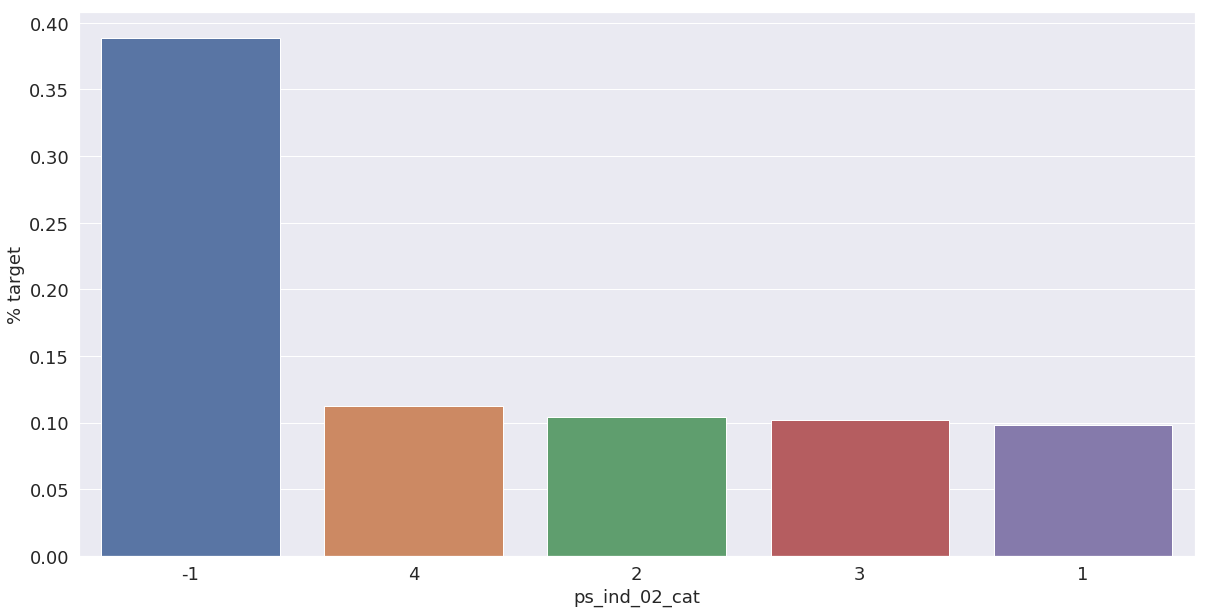

<Figure size 432x288 with 0 Axes>

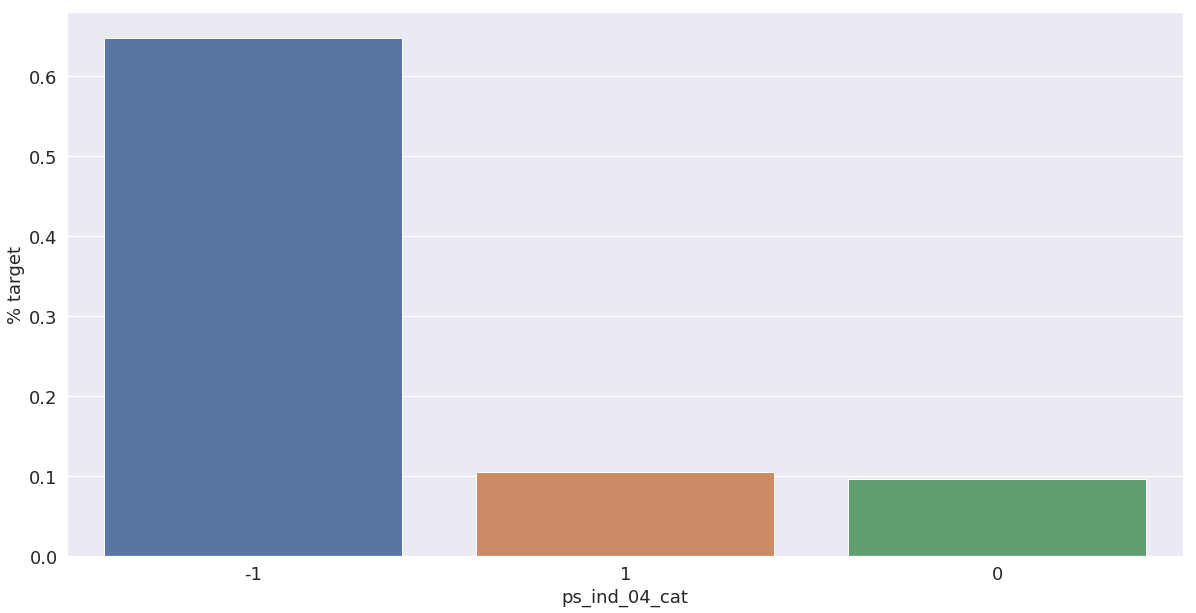

<Figure size 432x288 with 0 Axes>

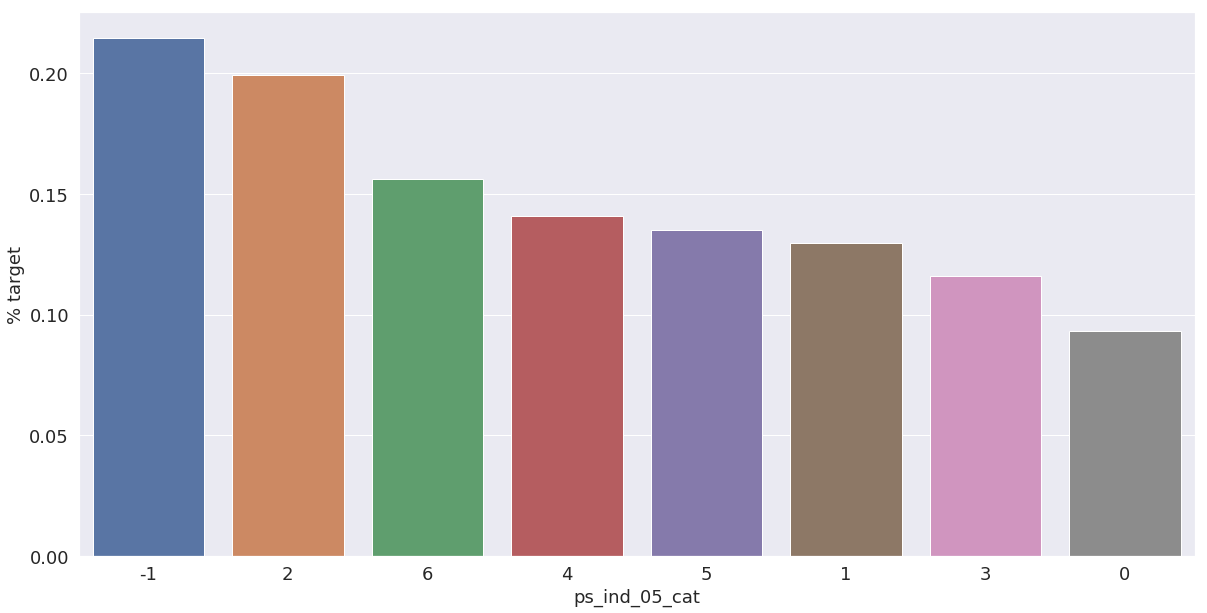

<Figure size 432x288 with 0 Axes>

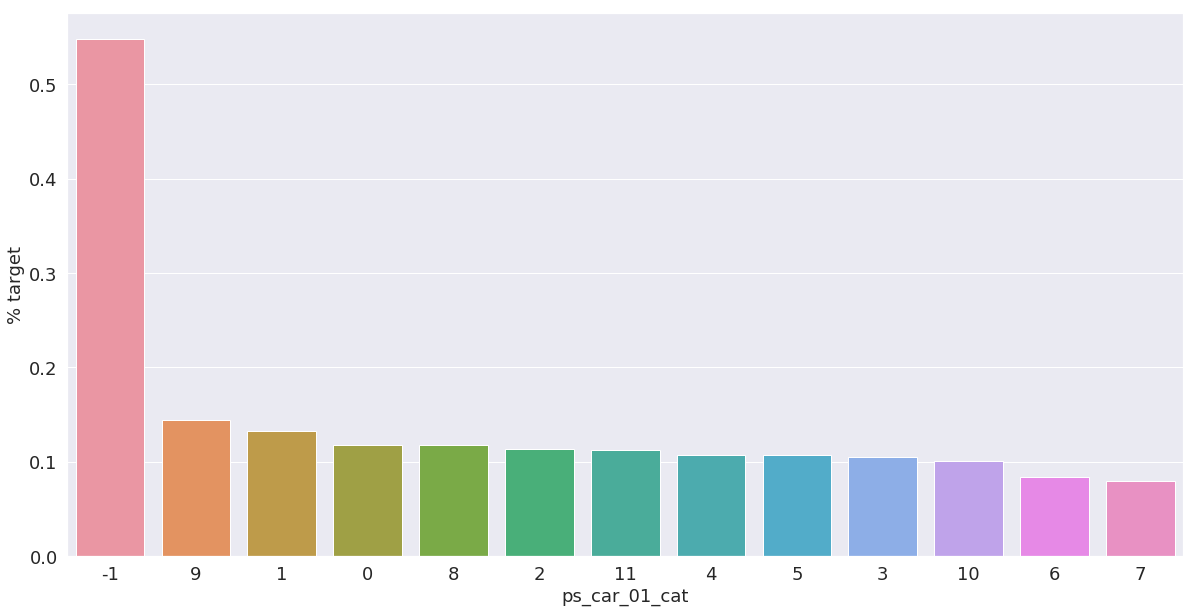

<Figure size 432x288 with 0 Axes>

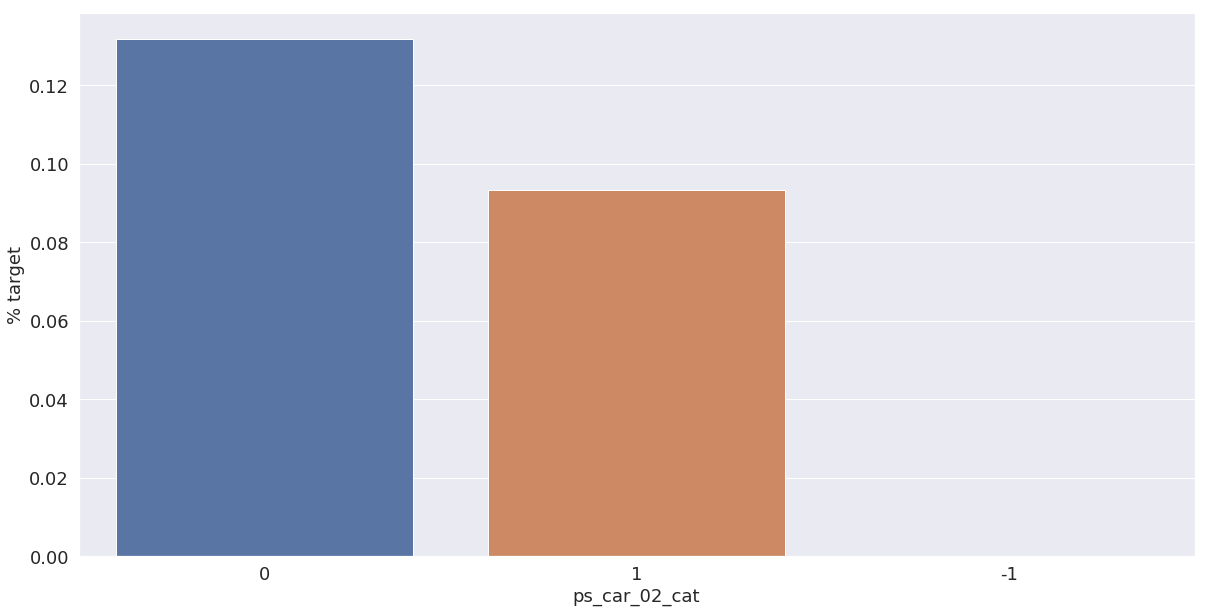

<Figure size 432x288 with 0 Axes>

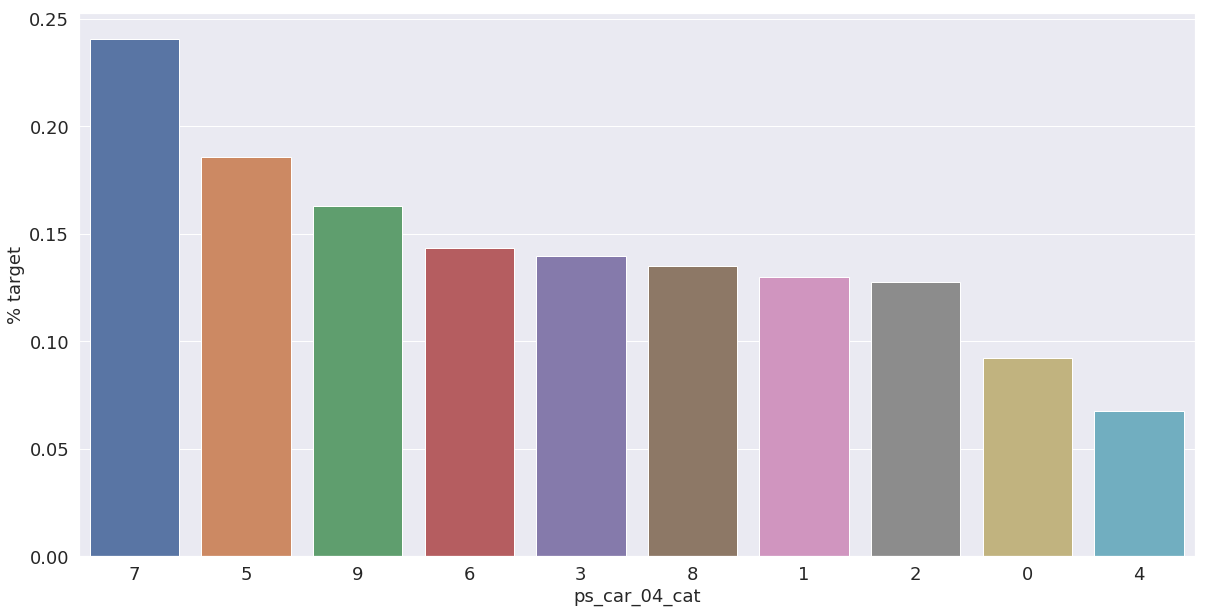

<Figure size 432x288 with 0 Axes>

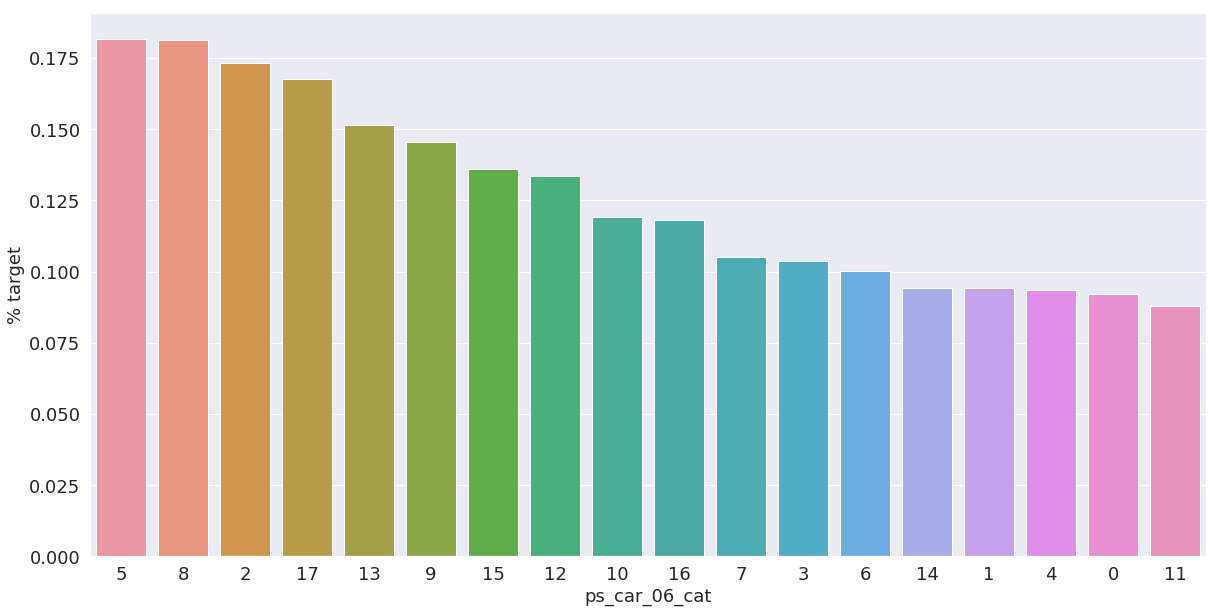

<Figure size 432x288 with 0 Axes>

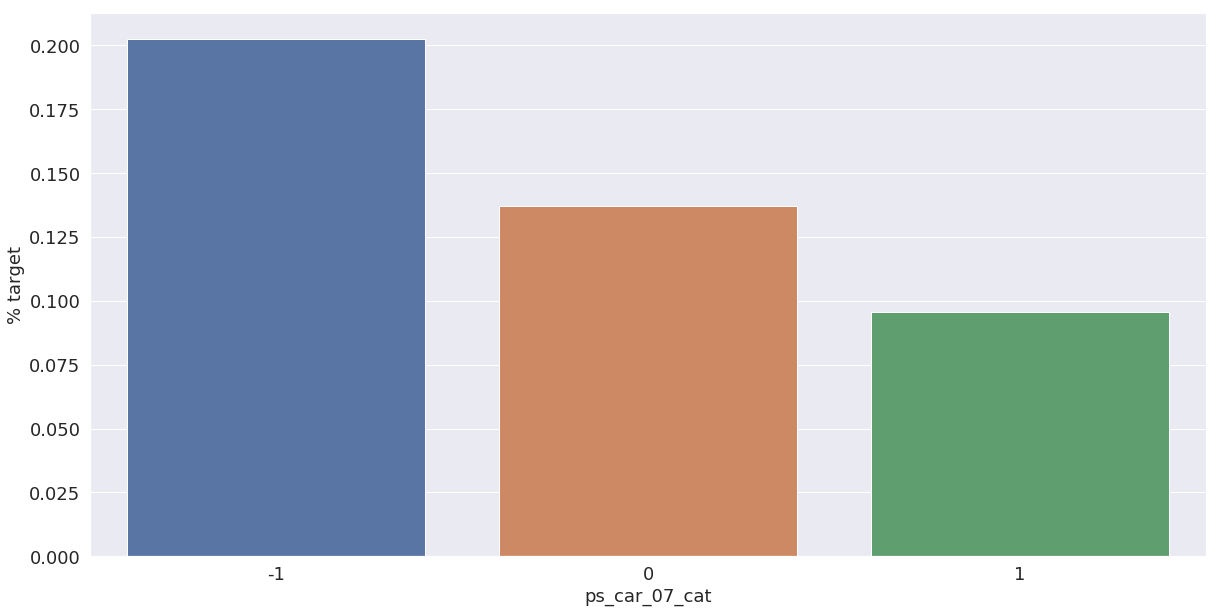

<Figure size 432x288 with 0 Axes>

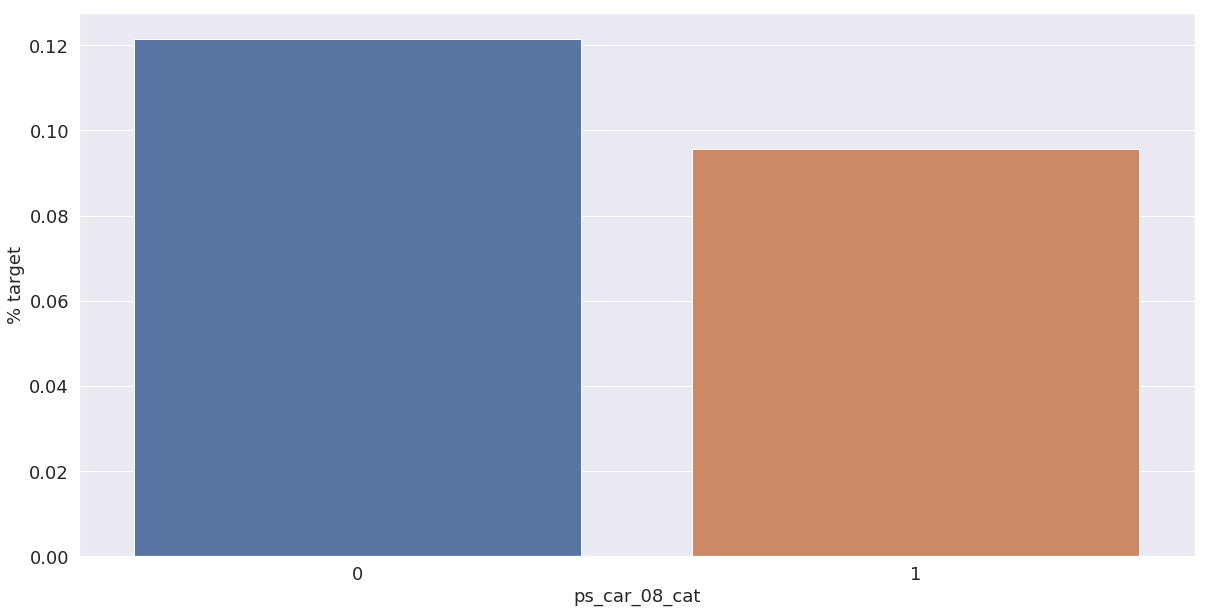

<Figure size 432x288 with 0 Axes>

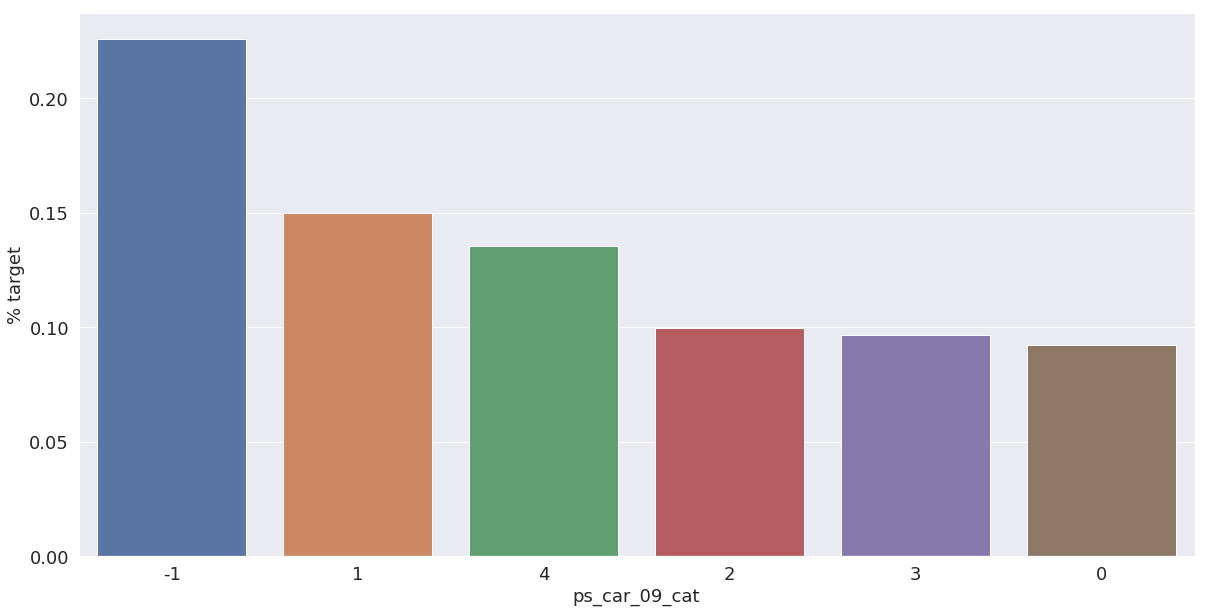

<Figure size 432x288 with 0 Axes>

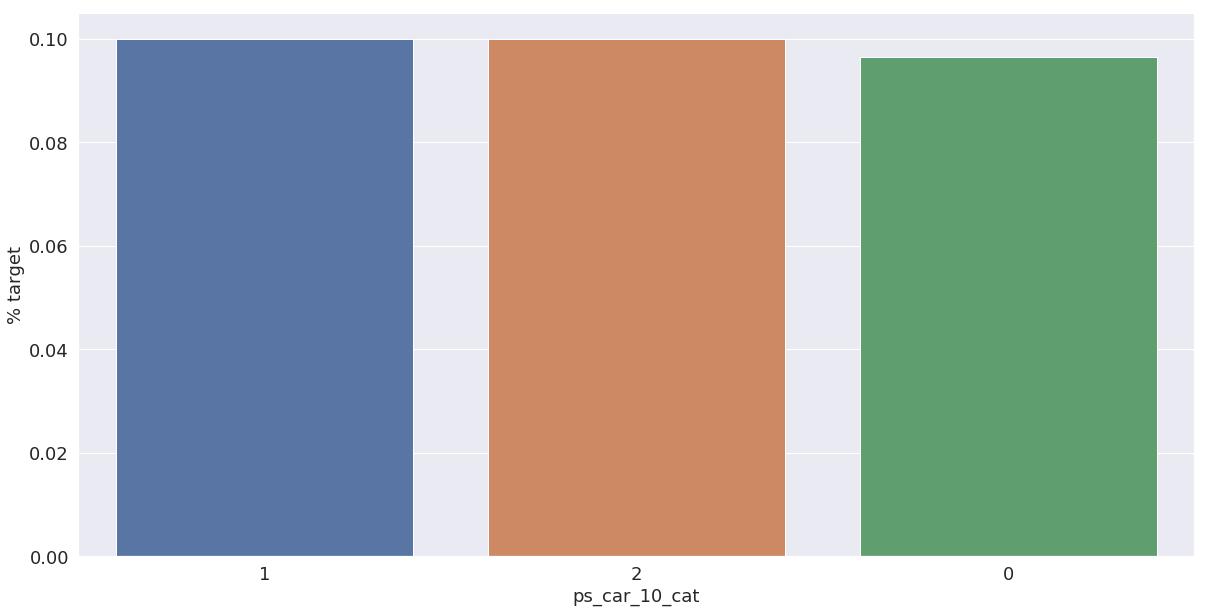

In [174]:
sns.set(font_scale=2)
for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();


As we can see from the variables with missing values, it is a good idea to keep the missing values as a separate category value, instead of replacing them by the mode for instance. The customers with a missing value appear to have a much higher (in some cases much lower) probability to ask for an insurance claim.

#### Interval variables
Checking the correlations between interval variables. A heatmap is a good way to visualize the correlation between variables. The code below is based on an example by Michael Waskom

In [175]:
sns.set(font_scale=1)

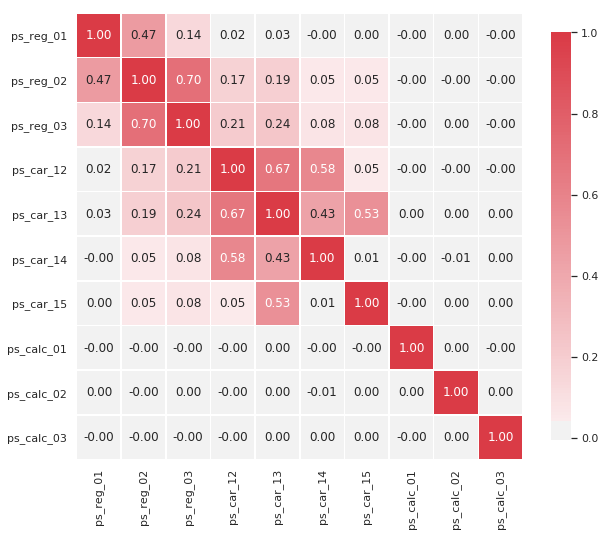

In [176]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

There are a strong correlations between the variables:

- ps_reg_02 and ps_reg_03 (0.7)
- ps_car_12 and ps_car13 (0.67)
- ps_car_12 and ps_car14 (0.58)
- ps_car_13 and ps_car15 (0.67)

Seaborn has some handy plots to visualize the (linear) relationship between variables. We could use a pairplot to visualize the relationship between the variables. But because the heatmap already showed the limited number of correlated variables, we'll look at each of the highly correlated variables separately.
NOTE: I take a sample of the train data to speed up the process.



In [177]:
s = train.sample(frac=0.1)

ps_reg_02 and ps_reg_03
As the regression line shows, there is a linear relationship between these variables. Thanks to the hue parameter we can see that the regression lines for target=0 and target=1 are the same.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


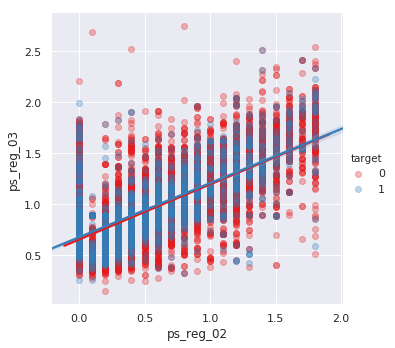

In [178]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

ps_car_12 and ps_car_13

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


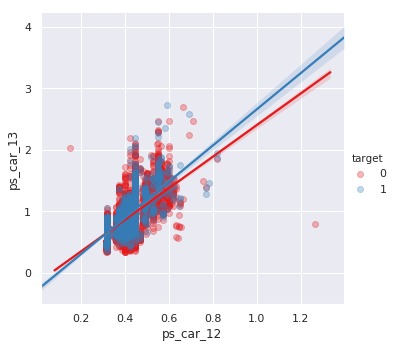

In [179]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

ps_car_12 and ps_car_14

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


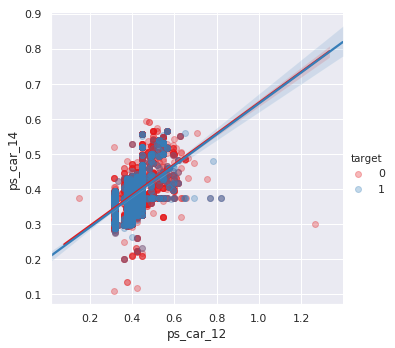

In [180]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

ps_car_13 and ps_car_15¶

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


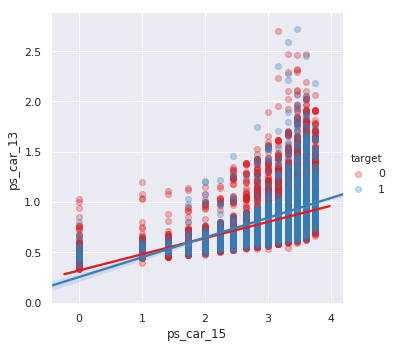

In [181]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

Allright, so now what? How can we decide which of the correlated variables to keep? We could perform Principal Component Analysis (PCA) on the variables to reduce the dimensions. In the AllState Claims Severity Competition I made this kernel to do that. But as the number of correlated variables is rather low, we will let the model do the heavy-lifting.

Checking the correlations between ordinal variables

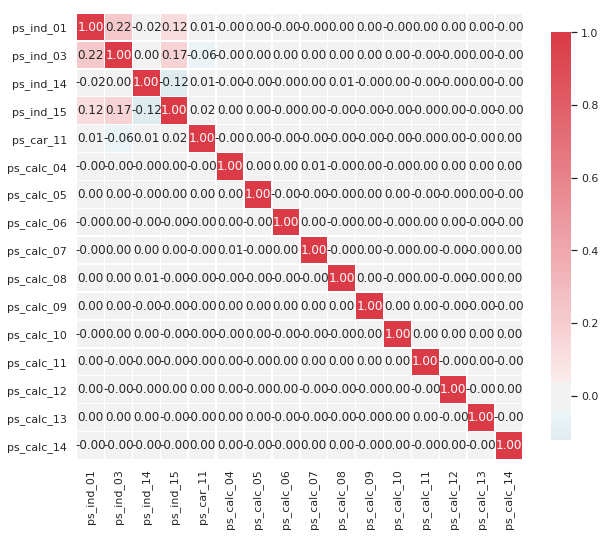

In [182]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

For the ordinal variables we do not see many correlations. We could, on the other hand, look at how the distributions are when grouping by the target value.

단순히 숫자만 뽑을 것이 아니라, 숫자를 믿지 말고 일일이 다시 그림을 그려보면서 분포에 맞는 값이 나온 건지 재확인 해봐야한다.(진짜 데이터포인트가 선형으로 되어있는지 아님 선형적인게 없는데 높은건지 확인을해야된다. 수치에 속지 말자)

### Feature engineering